## Sandox for Understanding and Developing ResNet Backbone for RetinaNet
Notes, ideas, and successive exploration of ResNet architecture using source academic papers.

## General Approach

<b>Use Fastai for data shenanigans and training.
<br>Use Pytorch for architecural planning and modeling.</b>

1. Download MNIST
- Build and train basic neural network in Fastai
- Build and train advanced neural network in Fastai
- Build and train linear model in Pytorch
- Build and train fixed convolutional model in Pytorch
- Build and train dynamic convolutional model in Pytorch
- Download CIFAR-10
- Build and train VGG19
- Build and train ResNet110

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
from fastai.vision import *
from fastai.datasets import *
from fastai.callbacks import *
from dataclasses import dataclass

## MNIST

In [42]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()

[PosixPath('/home/sudosharma/.fastai/data/mnist_sample/labels.csv'),
 PosixPath('/home/sudosharma/.fastai/data/mnist_sample/models'),
 PosixPath('/home/sudosharma/.fastai/data/mnist_sample/train'),
 PosixPath('/home/sudosharma/.fastai/data/mnist_sample/valid')]

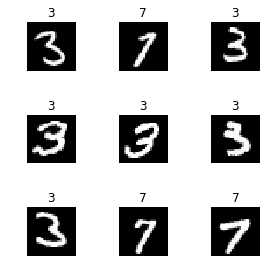

In [43]:
data = ImageDataBunch.from_folder(path)
data.show_batch(rows=3, figsize=(4, 4))

## NN v1

In [6]:
model = simple_cnn((3, 16, 16, 2))
learn = Learner(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
1,0.133678,0.106639,0.964181,00:01


## NN v2

In [7]:
model = models.resnet50
learn = create_cnn(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
1,0.146359,0.093797,0.969087,00:06


## NN v3

In [7]:
@dataclass
class PrintOutput(LearnerCallback):
    """Function to figure out if fastai is modifying final tensor before loss_func."""
    learn: Learner

    def on_loss_begin(self, **kwargs):
        if kwargs['num_batch'] == 1: print(kwargs['last_output'].shape)
        return kwargs['last_output']

    
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [8]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(3*28*28, 50), nn.ReLU(True),
    nn.Linear(50, 50)
)
learn = Learner(data, model, metrics=accuracy)
cb = PrintOutput(learn)
learn.fit(1, callbacks=[cb])

epoch,train_loss,valid_loss,accuracy,time
1,0.056079,0.093036,0.973503,00:01


torch.Size([64, 50])


## NN v4

In [9]:
model = nn.Sequential(
    nn.Conv2d(3, 256, 3, 1), nn.ReLU(True),
    nn.Conv2d(256, 128, 3, 1), nn.ReLU(True),
    nn.Conv2d(128, 64, 3, 1), nn.ReLU(True),
    nn.AdaptiveMaxPool2d(1),
    Flatten())
learn = Learner(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
1,0.122984,0.076745,0.974485,00:02


## NN v5

In [3]:
def conv(ic, oc, k=3, s=1, actn=False):
    """A conv layer module."""
    layers = [nn.Conv2d(ic, oc, k, stride=s, padding=k//2)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers)


class SimpleCNN(nn.Module):
    """A convnet block using module list approach."""
    def __init__(self, *cs):
        super().__init__()
        self.layers = nn.ModuleList(
            [conv(cs[i], cs[i+1], actn=True) for i in range(len(cs)-1)])
        self.layers.extend([nn.AdaptiveMaxPool2d(1), Flatten()])
        
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [11]:
model = SimpleCNN(3, 256, 128, 64)
learn = Learner(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
1,0.102602,0.102861,0.963690,00:02



## CIFAR-10

In [15]:
path = untar_data(URLs.CIFAR)
path.ls()

[PosixPath('/home/sudosharma/.fastai/data/cifar10/models'),
 PosixPath('/home/sudosharma/.fastai/data/cifar10/purge-tmp.pkl'),
 PosixPath('/home/sudosharma/.fastai/data/cifar10/test'),
 PosixPath('/home/sudosharma/.fastai/data/cifar10/labels.txt'),
 PosixPath('/home/sudosharma/.fastai/data/cifar10/train')]

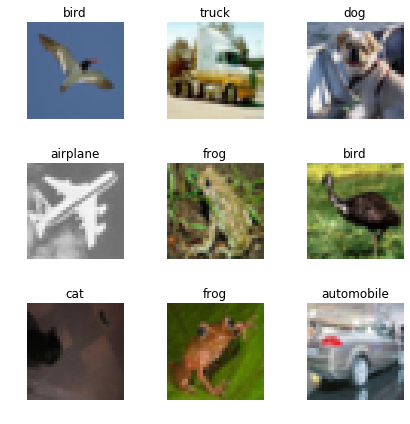

In [45]:
tfms = get_transforms(
    max_rotate=None, 
    max_zoom=1.0,  
    max_warp=None, 
    p_affine=0, 
    xtra_tfms=[rand_crop()])

data = (ImageList.from_folder(path)
        .split_by_folder(valid='test')
        .label_from_folder()
        .transform(tfms)
        .databunch(bs=256)
        .normalize(cifar_stats))

data.show_batch(3, figsize=(6, 6))

## NN v6 (VGG19)

In [4]:
class ConvBlock(nn.Module):
    """A conv block with pooling and 'l' convs."""
    def __init__(self, ic, oc, l, actn=True, pool=None):
        super().__init__()
        self.layers = nn.ModuleList([conv(ic, oc, actn=actn)])
        self.layers.extend(conv(oc, oc, actn=actn) for _ in range(l-1))
        if pool == 'max':
            self.layers.append(nn.MaxPool2d(2, stride=2))
        elif pool == 'avg':
            self.layers.append(nn.AvgPool2d(2, stride=2))
        
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x
                           
        
class VGG19(nn.Module):
    """A VGG implementation."""
    def __init__(self, actn=True, pool='max'):
        super().__init__()
        self.layers = nn.Sequential(
            ConvBlock(3, 64, 2, actn=actn, pool=pool),
            ConvBlock(64, 128, 2, actn=actn, pool=pool),
            ConvBlock(128, 256, 4, actn=actn, pool=pool),
            ConvBlock(256, 512, 4, actn=actn, pool=pool),
            ConvBlock(512, 512, 4, actn=actn, pool=pool),
            Flatten(),
            nn.Linear(512, 4096),
            nn.Dropout(0.5, inplace=True),
            nn.ReLU(True),
            nn.Linear(4096, 4096),
            nn.Dropout(0.5, inplace=True),
            nn.ReLU(True),
            nn.Linear(4096, 10))
    
    def forward(self, x):
        return self.layers(x)
    

def fit(learn, lr_epochs, wd=None, save='improvement'):
    """Fits learner with training phases, and saving functionality."""
    phases = [TrainingPhase(len(learn.data.train_dl)*e, lr, moms=0.9) for e, lr in lr_epochs]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    total_epochs = sum(e for e, _ in lr_epochs)
    learn.fit(
        total_epochs, 
        wd=wd, 
        callbacks=[SaveModelCallback(learn, every=save, monitor='accuracy', name='vgg19')])
    return learn

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


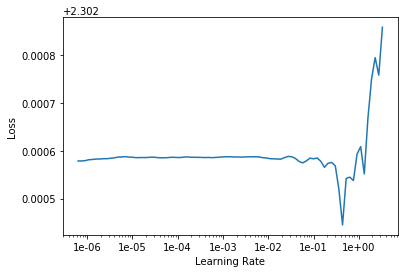

In [64]:
model = VGG19()
learn = Learner(data, model, metrics=accuracy, opt_func=torch.optim.SGD, loss_func=F.cross_entropy)
learn.init(nn.init.xavier_uniform_)
learn.lr_find()
learn.recorder.plot()

In [65]:
lr_epochs = [(5, 1e-4),(30, 1e-2), (25, 1e-3), (15, 1e-4)]
learn = fit(learn, lr_epochs, wd=5e-4)

epoch,train_loss,valid_loss,accuracy,time
1,2.302583,2.302568,0.128900,00:10
2,2.302564,2.302546,0.125600,00:10
3,2.302545,2.302526,0.117300,00:10
4,2.302526,2.302509,0.109800,00:10
5,2.302511,2.302496,0.126500,00:10
6,2.302836,2.302704,0.100000,00:10
7,2.302740,2.302520,0.100000,00:10
8,2.302511,2.302220,0.100000,00:10
9,2.300013,2.296085,0.149400,00:10
10,2.095595,1.972867,0.211000,00:11


Better model found at epoch 1 with accuracy value: 0.12890000641345978.
Better model found at epoch 9 with accuracy value: 0.149399995803833.
Better model found at epoch 10 with accuracy value: 0.210999995470047.
Better model found at epoch 11 with accuracy value: 0.23190000653266907.
Better model found at epoch 12 with accuracy value: 0.2799000144004822.
Better model found at epoch 13 with accuracy value: 0.3183000087738037.
Better model found at epoch 14 with accuracy value: 0.37560001015663147.
Better model found at epoch 15 with accuracy value: 0.427700012922287.
Better model found at epoch 16 with accuracy value: 0.46070000529289246.
Better model found at epoch 17 with accuracy value: 0.49900001287460327.
Better model found at epoch 18 with accuracy value: 0.5827000141143799.
Better model found at epoch 19 with accuracy value: 0.6371999979019165.
Better model found at epoch 20 with accuracy value: 0.6743000149726868.
Better model found at epoch 21 with accuracy value: 0.6872000098

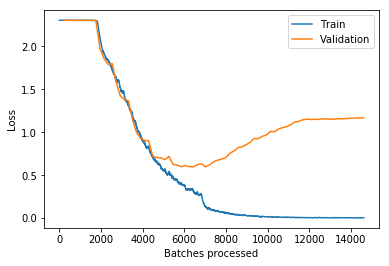

In [66]:
learn.recorder.plot_losses()

### VGG Analysis (Using CIFAR-10 performance against ImageNet as proxy)

In [4]:
pd.DataFrame({'VGG Paper top-1 val. error (%)': [25.5], 'Implementation top-1 val. error (%)': [(1-.842)*100]})

,VGG Paper top-1 val. error (%),Implementation top-1 val. error (%)
0,25.5,15.8


I only used the original optimizer, momentum, lr schedule, weight decay, architecture, initializations, and so on, from the original paper in 2015, so then:

<b>Why did this do so much better?</b>
- better hardware optimizations built-in with Nvidia
- fastai very opinionated, probably has optimizations I haven't discovered yet
- Most importantly, <b>CIFAR-10 a much easier dataset than ImageNet and has smaller images</b>

<b>Why did it not perform even better?</b>
- CIFAR-10 dataset pretty small
- hyperparameters tuned for ImageNet not CIFAR-10
- CIFAR-10 images are much lower quality
- batch size too high
- no RGB color shift (PCA color augmentation)
- no scale jittering
- obvious, but could have used all modern improvements (batch norm, adamw, 1cycle, etc.)

## NN v7 (ResNet-32  for CIFAR-10)

In [168]:
def conv(ic, oc, k=3, s=1, actn=True, bn=True):
    """A convolutional sequence with optional batch norm and relu activation."""
    layers = [nn.Conv2d(ic, oc, k, stride=s, padding=k//2)]
    if bn: layers.append(nn.BatchNorm2d(oc))
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers)


class ResBlock(nn.Module):
    """The tiniest unit in ResNet with two convolutional layers and a single identity skip connection."""
    def __init__(self, c, l=2, up_dim=False):
        super().__init__()
        self.up_dim = up_dim
        self.layers = [conv(c//2, c, s=2)] if up_dim else [conv(c, c)]
        self.layers.extend([conv(c, c) for _ in range(l-2)])
        self.layers.append(conv(c, c, actn=False))
        self.layers = nn.Sequential(*self.layers)
        self.identity = conv(c//2, c, k=1, s=2, actn=False, bn=False)
        
    def forward(self, x):
        if self.up_dim:
            return F.relu(self.layers(x) + self.identity(x))
        else:
            return F.relu(self.layers(x) + x)

        
class ResGroup(nn.Module):
    """A group of ResBlocks to make up a group with a specific filter size."""
    def __init__(self, c, b, up_dim=True):
        super().__init__()
        self.blocks = [ResBlock(c, up_dim=up_dim)]
        self.blocks.extend(ResBlock(c) for _ in range(b-1))
        self.blocks = nn.Sequential(*self.blocks)
    
    def forward(self, x):
        return self.blocks(x)
    
    
class ResNetCIFAR10(nn.Module):
    """The full ResNet architecture for CIFAR-10."""
    def __init__(self, n=18):
        super().__init__()
        self.layers = nn.Sequential(
            conv(3, 16), nn.MaxPool2d(3, stride=1, padding=3//2),
            ResGroup(16, 2*n, up_dim=False),
            ResGroup(32, 2*n),
            ResGroup(64, 2*n),
            nn.AdaptiveAvgPool2d(1),
            Flatten(),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    
def fit(learn, lr_epochs, wd=0.0001, save='improvement'):
    """Fits learner with training phases, and saving functionality."""
    phases = [TrainingPhase(len(learn.data.train_dl)*e, lr, moms=0.9) for e, lr in lr_epochs]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    total_epochs = sum(e for e, _ in lr_epochs)
    learn.fit(
        total_epochs,
        wd=wd,
        callbacks = [SaveModelCallback(learn, every=save, monitor='accuracy', name='resnet110_cifar10')])
    return learn

In [162]:
tfms = get_transforms(
    max_rotate=None, 
    max_zoom=1., 
    max_lighting=None, 
    max_warp=None, 
    xtra_tfms=[pad(padding=4), rand_crop(padding_mode='zeros')])

data = (ImageList.from_folder(path)
        .split_by_folder(valid='test')
        .label_from_folder()
        .transform(tfms)
        .databunch(bs=128)
        .normalize(cifar_stats))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


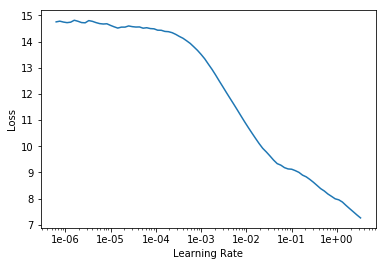

In [166]:
model = ResNetCIFAR10(n=18)
learn = Learner(data, model, metrics=accuracy, opt_func=torch.optim.SGD, loss_func=F.cross_entropy)
learn.init(nn.init.kaiming_normal_)
learn.lr_find()
learn.recorder.plot()

In [164]:
lr_epochs = [(1, 0.01), (82, 0.1), (42, 0.01), (42, 0.001)]
learn = fit(learn, lr_epochs)

epoch,train_loss,valid_loss,accuracy,time
1,1.671520,1.594889,0.407700,01:24
2,1.702403,1.779041,0.372200,01:24
3,1.436503,1.445136,0.457800,01:25
4,1.241446,1.261638,0.554300,01:25
5,1.108160,1.259041,0.578600,01:25
6,0.977271,0.949123,0.658700,01:25
7,0.897584,0.905572,0.688500,01:25
8,0.830208,0.880476,0.692700,01:25
9,0.761027,0.846063,0.720100,01:25
10,0.729219,0.774034,0.735000,01:25


Better model found at epoch 1 with accuracy value: 0.4077000021934509.
Better model found at epoch 3 with accuracy value: 0.4578000009059906.
Better model found at epoch 4 with accuracy value: 0.5543000102043152.
Better model found at epoch 5 with accuracy value: 0.5785999894142151.
Better model found at epoch 6 with accuracy value: 0.6586999893188477.
Better model found at epoch 7 with accuracy value: 0.6884999871253967.
Better model found at epoch 8 with accuracy value: 0.6927000284194946.
Better model found at epoch 9 with accuracy value: 0.7200999855995178.
Better model found at epoch 10 with accuracy value: 0.7350000143051147.
Better model found at epoch 12 with accuracy value: 0.7702000141143799.
Better model found at epoch 15 with accuracy value: 0.7736999988555908.
Better model found at epoch 16 with accuracy value: 0.8044999837875366.
Better model found at epoch 17 with accuracy value: 0.8198000192642212.
Better model found at epoch 18 with accuracy value: 0.8209999799728394.


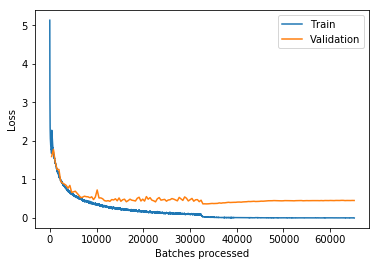

In [165]:
learn.recorder.plot_losses()

### ResNet Analysis (on CIFAR-10)

In [169]:
pd.DataFrame({'ResNet Paper top-1 val. error (%)': [6.43], 'Implementation top-1 val. error (%)': [(1-.913)*100]})

,ResNet Paper top-1 val. error (%),Implementation top-1 val. error (%)
0,6.43,8.7


I used the original paper's optimizer, lr schedule, and architectural choices, so then:

<b>Why did my implementation do so much worse?</b>
- I used a 1x1 conv for dimension matching during identity (B projection) instead of a simple identity. Maybe this increased complexity and led to some overfitting? Unlikely.
- I used a 50k/10k split instead of the original 45k/5k split, but intuitively this should've improved the validation error.
- Perhaps my data augmentation wasn't done properly. Most likely.
- The details in the paper are little murky about the placement of BN layers in the CIFAR-10 architecture.